# Experimental Analysis of Freivald's Algorithm

Freivald's algorithm is a randomized procedure to verify the correctness of matrix-matrix multiplication. Whereas the naive algorithm has a $O(n^3)$ runtime, Freivald's algorithms runs in $O(n^2)$ and is wrong only with small probability. In effect, the procedure takes as input three $n \times n$ matrices $A, B$ and $C$ and randomly generates a vector $X \in \{0,1\}^n$. It subsequently judges that the matrix $C$ is the result of a _incorrect_ multiplication of $A$ by $B$ if $A \cdot (B \cdot X) \neq C \cdot X$, otherwise it concludes that the multiplication is _probably correct_. We can see that Freivald's algorithm is correct 100% of the time when it says that $C$ is not the correct result of multiplying $A$ by $B$. But, how often should we trust it when it says that the multiplication is correct? There is a theoretical argument that the algorithm is right with probability at least $1/2$ when it says that the multiplication is correct [1]. In this report, we make an empirical analysis of this result.

The language of implementation is the Python programming language with the NumPy library for faster numerical computation and the matplotlib library for visualization.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 

%matplotlib inline

## Implementation

The function **is_correct_mult** is our implementation of Freivald's algorithm. It proceeds as described in the introduction. In addition it takes an optional parameter $k$ defaulting to $1$ that controls the number of time the verification is done before returning a _positive_ result. Intuitively, multiple verification using independent generations of $X$ that $A \cdot (B \cdot X) \neq C \cdot X$ will increase the likelihood that $A \cdot B = C$.

In [2]:
def is_correct_mult(A, B, C, k=1):
    """Freivald's algorithm to test if the dot product of A and B equals C."""
    n = A.shape[0]                         # a, b are n x n matrices
    for _ in range(k):
        X = np.random.randint(0, 2, (n,))  # X is a vector in {0,1}^n
        res = A @ (B @ X) - (C @ X)
        if res.any():
            return False                   # A TOTALLY FALSE multiplication
    return True                            # A PROBABLY CORRECT multiplication
    

## Experiment design

The function **make_test** is a helper to generate wrong multiplication of random square matrices of dimension $n$. It fills matrices $A$ and $B$ with random values, correctly computes their product and insert an error in a randomly choosen cell. At last, it returns the matrices $A$, $B$ with the incorrect result of their multiplication.

In [3]:
def make_test(n):
    """Simulate an incorrect multiplication of random N x N matrices."""
    A = np.random.random((n,n))
    B = np.random.random((n,n))
    correct = A @ B
    
    # Artificially make an error in a random cell
    incorrect = correct.copy()
    i, j = np.random.randint(0, n, 2)
    incorrect[i,j] +=  np.random.random()
  
    return A, B, incorrect

We can now proceed with the heart of the experiment. We count the number of times **is_correct_mult** successfully judges a wrong multiplication in $10,000$ iterations for each $n$ ranging from $2$ to $100$ with both $k = 1$ and $k = 2$ for each input.

In [4]:
lo, hi = 2, 100

good_counts = []
good_counts_with_k2 = []
for n in range(lo, hi+1):
    good_answers, good_answers_with_k2 = 0, 0
    for _ in range(10_000):
        A, B, C = make_test(n)
        good_answers += 1 if not is_correct_mult(A, B, C) else 0
        good_answers_with_k2 += 1 if not is_correct_mult(A, B, C, k=2) else 0
    good_counts.append(good_answers)
    good_counts_with_k2.append(good_answers_with_k2)


## Analysis


The results for $k = 1$ show that more than half of the time **is_correct_mult** successfully spot the incorrect multiplication. This observation is consistent with the theoretical results mentioned in the introduction. Also, it seems that the likelihood of not finding the error decreases as $n$ increases. This might be a consequence of how we designed the experiment. But an intuitive explanation could be: since we are summing a _random selection of columns vectors_ from $A \cdot B$ and $C$ before comparing them, it makes sense that the chances to miss the column containing the wrong cell in $C$ decreases as the number of columns increases. In theory however, this analysis is not true. Since each column is selected independently of the others to be included in the sum with probability $1/2$, the probability of the wrong column being included in $C \cdot X$ remain $1/2$ independently of the value of $n$.

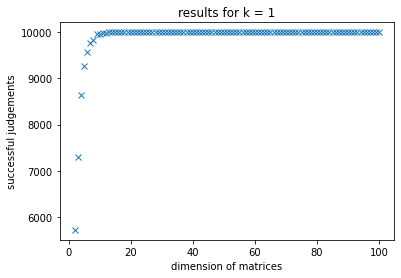

In [5]:
plt.plot(np.arange(lo,hi+1), good_counts, 'x')
plt.xlabel('dimension of matrices')
plt.ylabel('successful judgements')
plt.title('results for k = 1')
plt.show()

On the other hand, the results for $k = 2$ show that slighly increasing the number of independent verifications decreases the probability of a false-positive. Indeed, Freivald's algorithm is a _NO-biased 1/2-correct_ Monte-Carlo algorithm. This means that when it says that the multiplication is wrong it is 100% sure, but it could be wrong with probability at most $1/2$ when it says that the multiplication is correct. A property shared by b-biased p-correct Monte-Carlo algorithms is that $k$ independent runs of the procedure decreases the probability of a false-positives to being at most $p^{-k}$  [2]. So we would expect at most $2,500$ wrong judgements out of $10,000$ executions. Our observation is consistent with this result.

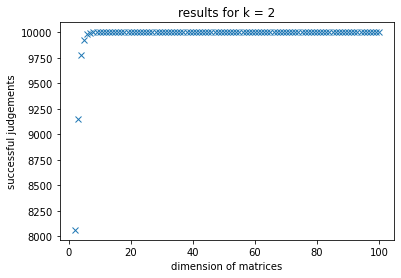

In [6]:
plt.plot(np.arange(lo,hi+1), good_counts_with_k2, 'x')
plt.xlabel('dimension of matrices')
plt.ylabel('successful judgements')
plt.title('results for k = 2')
plt.show()

## References

[1] https://courses.cs.washington.edu/courses/cse312/14wi/freivalds.pdf  
[2] Foundations of Algorithms, Chapter 8, Yoshihide Igarashi and Yasuaki Nishitani

# A Complex Situation or A Case for Complexity

As a graduate in Hamana's Laboratory, most of the questions I encounter deal with computability rather than complexity. For example, in the theory of Term Rewriting Systems, we are usually interested in finding out if a given Term Rewrite System (TRS) is _terminating_ and/or _confluent_. Simply put, TRSs give rules according to which terms built from a given alphabet can be transformed (with the goal of simplification by reducing a certain mesure of terms). An example of TRS is the usual rules of arithmetics ($+,-,\times, \div$) where the set of terms are expressions others natural numbers. Term Rewrite Systems have application in automated theorem provers and functional programming etc. Now, A TRS is terminating if there are no infinite transformation sequence for all terms and is confluent if any occuring branching (encoding non-determinism) in a reduction step can be joined back. Termination and confluence are generally undecidable; so we are very happy when a researcher figures out some conditions on TRSs that make either one of these properties decidable. These conditions are often given in the form: if conditions $C_1, C_2, ..., C_n$ hold then given TRS has property $p$. Some sets of conditions may result in simpler decision procedures than others, but they can still be difficult to check algorithmically. I am very new to the litterature of this field, and my inexperienced opinion is that the skill of the programmer (in choosing efficient data structures for example) can greatly influence the complexity of the resulting implementation.

# On _P vs NP_

Seing how much brain power has being thrown at it since it was first asked, I can only conclude that we probably don't yet have the necessary mathematical tools to answer it. But I don't know much mathematics so my opinion doesn't count. In any case, the problem ask an important question with important consequences regardless of the solution, so that I only wish to be alive when it is resolved. If we assume that time will run indefinitely, then we can all agree that the chances of the problem being solved one day is non-zero. So another not less important question is whether we will live to see the solution.
